## Import Libraries

In [262]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [263]:
pd.set_option('display.max_rows', 50)

## Import Datasets

In [264]:
train_data = pd.read_csv("Kaggle_Dataset/PM_train.txt", sep=" ", header=None)
test_data = pd.read_csv("Kaggle_Dataset/PM_test.txt", sep=" ", header=None)
ground_truth = pd.read_csv("Kaggle_Dataset/PM_truth.txt", sep=" ", header=None)

### Drop Empty Columns

In [265]:
train_data.dropna(axis=1, inplace=True)
test_data.dropna(axis=1, inplace=True)
ground_truth.dropna(axis=1, inplace=True)

### Label Columns

In [266]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_data.columns = cols_names
test_data.columns = cols_names

### Sort columns by the attributes 'id' and 'cycle'

In [267]:
train_data = train_data.sort_values(['id', 'cycle'])
test_data = test_data.sort_values(['id', 'cycle'])

### Normalize training data in all columns that are different to 'id' and 'cycle'

In [268]:
norm_cols = train_data.columns.difference(['id', 'cycle'])

min_max_scaler = preprocessing.MinMaxScaler()

norm_train_data = pd.DataFrame(min_max_scaler.fit_transform(train_data[norm_cols]), 
                               columns=norm_cols, index=train_data.index)

join_train_data = train_data[["id", "cycle"]].join(norm_train_data)

train_data = join_train_data.reindex(columns = train_data.columns)


### Normalize test data in all columns that are different to 'id' and 'cycle'

In [269]:
norm_cols = test_data.columns.difference(['id', 'cycle'])

min_max_scaler = preprocessing.MinMaxScaler()

norm_test_data = pd.DataFrame(min_max_scaler.fit_transform(test_data[norm_cols]), 
                               columns=norm_cols, index=test_data.index)

join_test_data = test_data[["id", "cycle"]].join(norm_test_data)

test_data = join_test_data.reindex(columns = test_data.columns)

In [270]:
def create_rul_column(data):
    rul = pd.DataFrame(data.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    data = data.merge(rul, on=['id'], how='left')
    data['RUL'] = data['max'] - data['cycle']
    data.drop('max', axis=1, inplace=True)
    return data

train_data = create_rul_column(train_data)
test_data = create_rul_column(test_data)

In [271]:
# Remove columns with only one unique value
train_data = train_data.loc[:, train_data.apply(pd.Series.nunique) != 1]
test_data = test_data.loc[:, test_data.apply(pd.Series.nunique) != 1]

# remove sensor 6, setting 1 and setting 2
train_data = train_data.drop(['s6', 'setting1', 'setting2'], axis=1)
test_data = test_data.drop(['s6', 'setting1', 'setting2'], axis=1)

# Fill missing values with the mean
train_data = train_data.fillna(train_data.mean())

In [272]:
# smooth the data using rolling average on sensors
omit_cols = ['id', 'cycle', 'RUL']
sensor_cols = train_data.columns.difference(omit_cols)

train_data_smooth = train_data.copy()
train_data_smooth.loc[:, sensor_cols] = train_data_smooth.loc[:, sensor_cols].rolling(window=5).median()
train_data_smooth = train_data_smooth.dropna()
train_data = train_data_smooth

test_data_smooth = test_data.copy()
test_data_smooth.loc[:, sensor_cols] = test_data_smooth.loc[:, sensor_cols].rolling(window=5).median()
test_data_smooth = test_data_smooth.dropna()
test_data = test_data_smooth

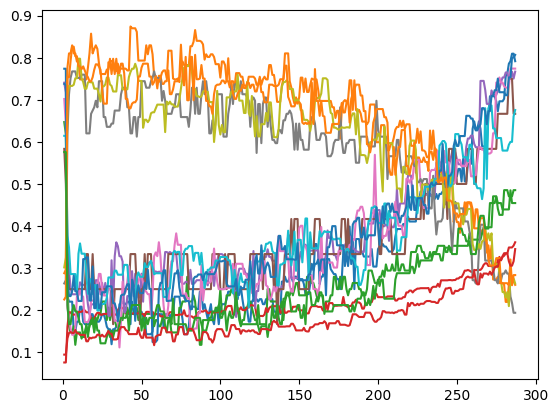

In [273]:
# EDA
# Plot Sensor data in relation to cycles

# Plot dynamic sensor data
for i in train_data.columns.difference(['id', 'cycle', 'RUL']):
    plt.plot(train_data[train_data["id"] == 2]["cycle"], train_data[i][train_data["id"] == 2], label=i)
    #plt.show()
    #print(i)


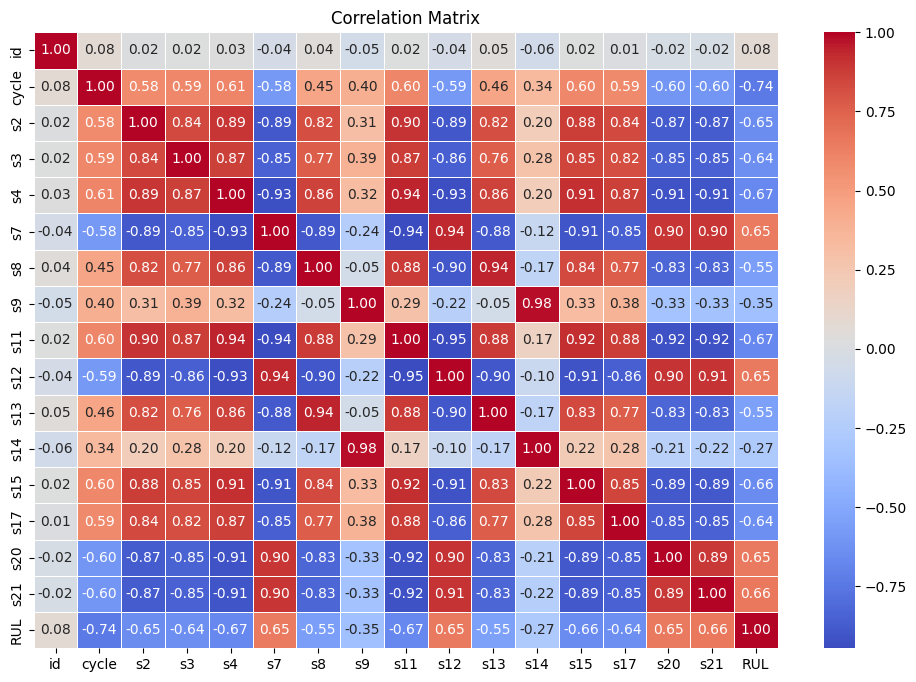

In [274]:
# Compute the correlation matrix
corr = train_data.corr()

# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [275]:
# Remove s9, s13, s8, s3 and s14 as they dont have a high correlation with the RUL
train_data = train_data.drop(['s9', 's14'], axis=1)
test_data = test_data.drop(['s9', 's14'], axis=1)

In [276]:
# Set up the data for the model
X_train = train_data.drop(['RUL'], axis=1)
X_test = test_data.drop(['RUL'], axis=1)

y_train = train_data['RUL']
y_test = test_data['RUL']
test_data.head(50)

,id,cycle,s2,s3,s4,s7,s8,s11,s12,s13,s15,s17,s20,s21,RUL
4,1,5,0.419558,0.464814,0.346130,0.651210,0.341463,0.349315,0.591324,0.325581,0.337009,0.375,0.627273,0.645718,26
5,1,6,0.413249,0.464814,0.346130,0.661290,0.292683,0.349315,0.591324,0.372093,0.337009,0.375,0.627273,0.645718,25
6,1,7,0.413249,0.391587,0.357974,0.651210,0.341463,0.349315,0.591324,0.372093,0.337009,0.250,0.618182,0.650814,24
7,1,8,0.413249,0.371332,0.357974,0.643145,0.341463,0.328767,0.600457,0.395349,0.337009,0.250,0.618182,0.620382,23
8,1,9,0.309148,0.371332,0.357974,0.661290,0.390244,0.349315,0.605023,0.395349,0.424257,0.250,0.618182,0.650814,22
9,1,10,0.309148,0.371332,0.336941,0.673387,0.390244,0.315068,0.600457,0.395349,0.424257,0.250,0.545455,0.632130,21
10,1,11,0.296530,0.371332,0.396978,0.685484,0.390244,0.294521,0.600457,0.395349,0.366731,0.250,0.672727,0.632130,20
11,1,12,0.296530,0.420930,0.336941,0.699597,0.365854,0.294521,0.600457,0.395349,0.366731,0.250,0.681818,0.632130,19
12,1,13,0.287066,0.477538,0.396978,0.699597,0.365854,0.321918,0.600457,0.395349,0.366731,0.250,0.700000,0.632130,18
13,1,14,0.296530,0.420930,0.377578,0.699597,0.341463,0.301370,0.598174,0.395349,0.366731,0.250,0.681818,0.632130,17


In [277]:
# Training the model	
model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Visualizing learning curves
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2)

Epoch 1/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step - loss: 5165.2988 - val_loss: 3384.5439
Epoch 2/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step - loss: 1312.9774 - val_loss: 2745.0569
Epoch 3/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step - loss: 1192.4587 - val_loss: 2888.5862
Epoch 4/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/step - loss: 1154.6333 - val_loss: 2502.9932
Epoch 5/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - loss: 1163.0919 - val_loss: 2505.1807
Epoch 6/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step - loss: 1140.9136 - val_loss: 2567.1841
Epoch 7/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step - loss: 1082.4015 - val_loss: 2563.1289
Epoch 8/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - loss: 1066.1055 - val_loss: 2504.2971
Epoch 9/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step - loss: 1075.7909 - val_loss: 2638.9524
Epoch 10/30
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - loss: 1055.2451 - val_loss: 2398.2900
Epoch 11/30
1032/1032 ━━━━━━━━━━━━━━━━━

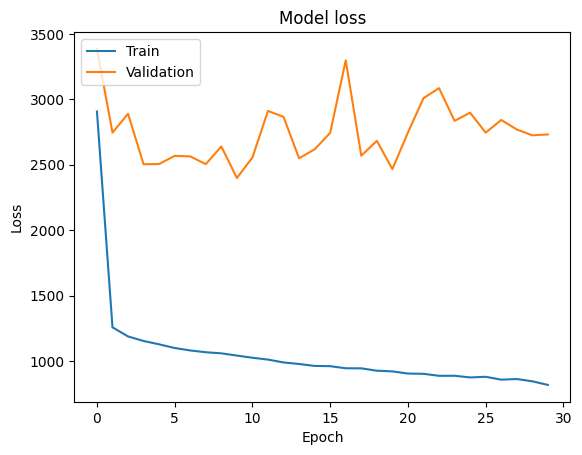

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
Predicted RUL:  [ 1792.3141  3176.192   7856.636   6661.247   6181.7905  6581.888
  9922.605  10268.068   3561.8389 11861.838   5239.2227 13400.31
 12012.982   3014.4087  4834.317   7045.289  10188.962   8265.613
  8407.392  11361.113   9231.156   2576.754   8096.407  11459.523
  3139.176   4798.48    8660.693   9786.773  10589.127   8863.92
 12105.752   9046.026   3232.7703 12520.542  12292.219   7919.8247
  7594.5356  7831.4653  2476.5012  8246.189   7708.5166  9709.21
 10703.502   3506.9702  9426.342   9087.992   4659.1616  4956.3286
 18579.81    4756.879   8932.316  11673.505  10164.489   7549.4175
  7041.62    8465.459   9972.785  10900.957   5956.657   9111.91
  9848.82   14308.019   9614.035  10418.8545  4554.364   9107.701
  4542.1978 11526.968   3546.3472  9425.833   4339.764   8132.6353
  7013.6406  8507.996   5542.932  12633.293  10078.859   4609.8975
  6301.7964  8272.801  13121.379  10090.078   4713.8784 10632.875
  2291.1829  6863.65

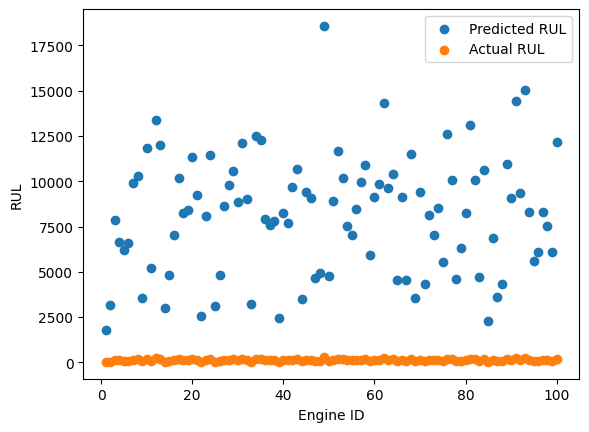

In [280]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Filter the test data to only include the first cycle for each engine ID
first_cycle_test_data = test_data.groupby('id').first()

# Predict the RUL for the first cycle of each engine
y_pred = model.predict(first_cycle_test_data)

# Flatten the predictions
y_pred = y_pred.flatten()

y_test = test_data.groupby('id').first()['RUL']

print('Predicted RUL: ', y_pred, '\n', 'Actual RUL: ', y_test)
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: ', rmse)

# Calculate the MAE
mae = mean_absolute_error(y_test, y_pred)
print('MAE: ', mae)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print('R^2 score: ', r2)

# Get the unique engine IDs
engine_ids = test_data_smooth['id'].unique()

# Ensure that y_pred is numpy array
y_pred = np.array(y_pred)

# Plot the engine ID vs the predicted RUL
plt.scatter(engine_ids, y_pred, label='Predicted RUL')

# Plot the engine ID vs the actual RUL
plt.scatter(engine_ids, y_test, label='Actual RUL')

plt.xlabel('Engine ID')
plt.ylabel('RUL')
plt.legend()
plt.show()